## Customer Segmentation

In [1]:
import pandas as pd

data = pd.read_csv('Wholesale customers data.csv')
data.drop(['Channel', 'Region'], axis=1, inplace=True)
print(data.shape)
data.head()

(440, 6)


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,12669,9656,7561,214,2674,1338
1,7057,9810,9568,1762,3293,1776
2,6353,8808,7684,2405,3516,7844
3,13265,1196,4221,6404,507,1788
4,22615,5410,7198,3915,1777,5185


In [2]:
# Statistics
stats = data.describe()
stats

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
count,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000
mean,12000.297727,5796.265909,7951.277273,3071.931818,2881.493182,1524.870455
std,12647.328865,7380.377175,9503.162829,4854.673333,4767.854448,2820.105937
min,3.000000,55.000000,3.000000,25.000000,3.000000,3.000000
25%,3127.750000,1533.000000,2153.000000,742.250000,256.750000,408.250000
50%,8504.000000,3627.000000,4755.500000,1526.000000,816.500000,965.500000
75%,16933.750000,7190.250000,10655.750000,3554.250000,3922.000000,1820.250000
max,112151.000000,73498.000000,92780.000000,60869.000000,40827.000000,47943.000000


### Selecting Samples

In [3]:
# Select some samples to track
data.loc[[100,200,300],:]

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
100,11594,7779,12144,3252,8035,3029
200,3067,13240,23127,3941,9959,731
300,16448,6243,6360,824,2662,2005


We can filter samples that are starkly different based on the quartiles.

In [4]:
fresh_q1 = stats.loc['25%']['Fresh']
frozen_q1 = stats.loc['25%']['Frozen']
frozen_q3 = stats.loc['75%']['Frozen']

* Fresh filter

In [5]:
data[data['Fresh']<fresh_q1].head()

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
16,1020,8816,12121,134,4508,1080
31,2612,4339,3133,2088,820,985
34,1502,1979,2262,425,483,395
35,688,5491,11091,833,4239,436
43,630,11095,23998,787,9529,72


* Frozen filter

In [6]:
data[data['Frozen']<frozen_q1].head()

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,12669,9656,7561,214,2674,1338
5,9413,8259,5126,666,1795,1451
6,12126,3199,6975,480,3140,545
8,5963,3648,6192,425,1716,750
12,31714,12319,11757,287,3881,2931


In [7]:
data[data['Frozen']>frozen_q3].head(7)

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
3,13265,1196,4221,6404,507,1788
4,22615,5410,7198,3915,1777,5185
10,3366,5403,12974,4400,5977,1744
22,31276,1917,4469,9408,2381,4334
23,26373,36423,22019,5154,4337,16523
33,29729,4786,7326,6130,361,1083
39,56159,555,902,10002,212,2916


We select three samples from the dataset

In [8]:
indices = [43, 12 ,39]
samples = data.loc[indices,:]
samples.reset_index(drop=True)

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,630,11095,23998,787,9529,72
1,31714,12319,11757,287,3881,2931
2,56159,555,902,10002,212,2916


### Comparison of Samples and Means

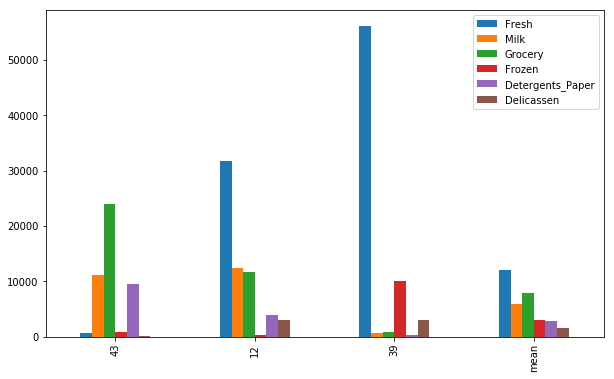

In [32]:
# Get the means 
mean_data = data.describe().loc['mean',:]

# Append means to the samples' data
samples_bar = samples.append(mean_data)

# Plot samples
import seaborn as sns
samples_bar.plot(kind='bar', figsize=(10, 6))

* 43: Very low "Fresh" and very high "Grocery"
* 12: Very low "Frozen" and very high "Fresh"
* 39: Very high "Frozen" and very low "Detergens_Paper"

### Comparing Samples' Percentiles

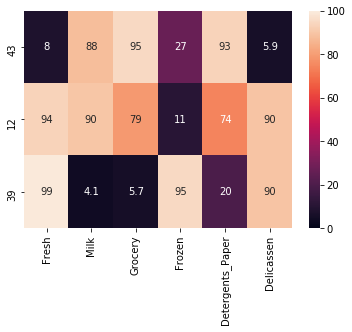

In [10]:
percentiles = data.rank(pct=True)
percentiles = 100*percentiles.round(decimals=3)
percentiles = percentiles.iloc[indices]
sns.heatmap(percentiles, vmin=0, vmax=100, annot=True)

From the analysis of the three indices above we can assume following customer types:
* 43: Coffee Cafe
* 12: Upscale Restaurant
* 39: Fresh Food Retailer 

### Feature Relevance
Is one (or more) of the six product categories actually relevant for understanding customer purchasing? That is to say, is it possible to determine whether customers purchasing some amount of one category of products will necessarily purchase some proportional amount of another category of products? 

In [11]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor

In [12]:
dep_vars = list(data.columns)

for var in dep_vars:
    # drop one feature at a time
    new_data = data.drop([var], axis=1)
    new_feature = data.loc[:, var]
    
    X_train, X_test, y_train, y_test = train_test_split(new_data, new_feature, test_size=0.25, random_state=42)

    # Instantiate Model
    dtr = DecisionTreeRegressor(random_state=42)
    # Fit Model
    dtr.fit(X_train, y_train)
    # Returns R^2
    score = dtr.score(X_test, y_test)
    print('R2 score for {} as dependent variable: {}'.format(var, score))

R2 score for Fresh as dependent variable: -0.38574971020407384
R2 score for Milk as dependent variable: 0.15627539501732116
R2 score for Grocery as dependent variable: 0.6818840085440834
R2 score for Frozen as dependent variable: -0.21013589012491396
R2 score for Detergents_Paper as dependent variable: 0.27166698062685013
R2 score for Delicassen as dependent variable: -2.254711537203931


* "Fresh", "Frozen" and "Delicatessen" as dependent variables have negative scores, which imply that they are necessary for identifying customers' spending habits because the remaining features cannot explain the variation in them.
* "Milk" and "Detergents_Paper" have very low R2 scores, which also imply that they are necessary for identifying customers' spending habits.
* "Grocery" has a R2 score of 0.68, which relative to the others it is much higher, but we are not still sure that this variable is necessary. 

### Visualize Feature Distributions

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000000001C40A710>,
      dtype=object)

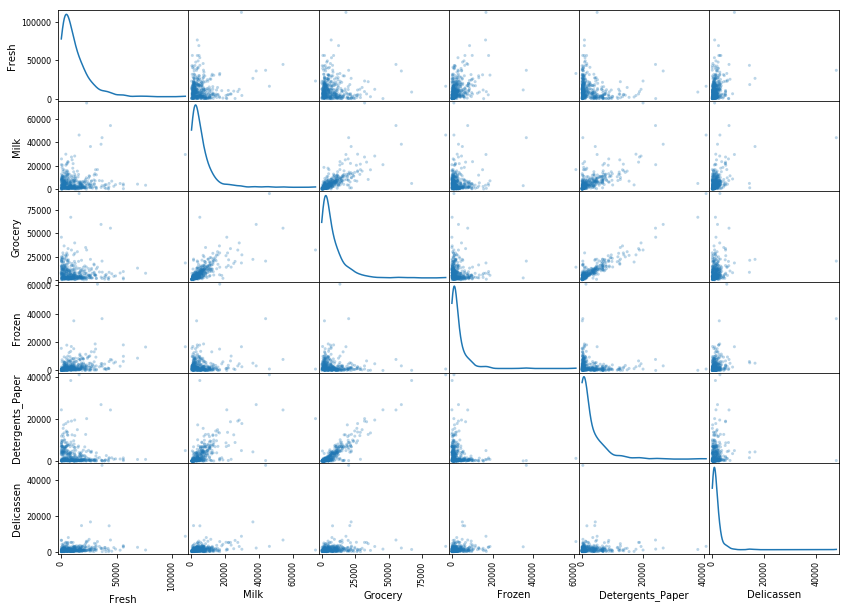

In [13]:
from pandas.plotting import scatter_matrix
scatter_matrix(data, alpha = 0.3, figsize = (14,10), diagonal = 'kde')

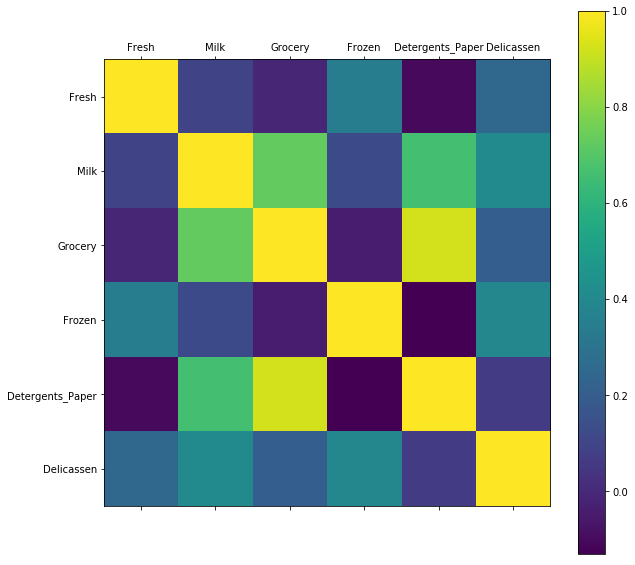

In [14]:
import matplotlib.pyplot as plt
%matplotlib inline

def plot_corr(df):
    corr = df.corr()
    fig, ax = plt.subplots(figsize=(10, 10))
    cax = ax.matshow(corr)
    cbar = fig.colorbar(cax)
    plt.xticks(range(len(corr.columns)), corr.columns);
    plt.yticks(range(len(corr.columns)), corr.columns);
    plt.show()
    
plot_corr(data)

Features that are strongly correlated are:
* Grocery and Detergents_Paper.
* Grocery and Milk.
* Detergents_Paper and Milk (not too strong).

This result enforce our initial claim that Grocery may not be necessary for identifying customers' spending habits.

### Data Preprocessing
#### Feature Scaling
The data are not normally distributed. We apply Box-Cox Test to reduce skewness. 

In [15]:
# Apply the natural logarithm
import numpy as np
log_data = np.log(data)

log_samples = np.log(samples)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000000001CD00BA8>,
      dtype=object)

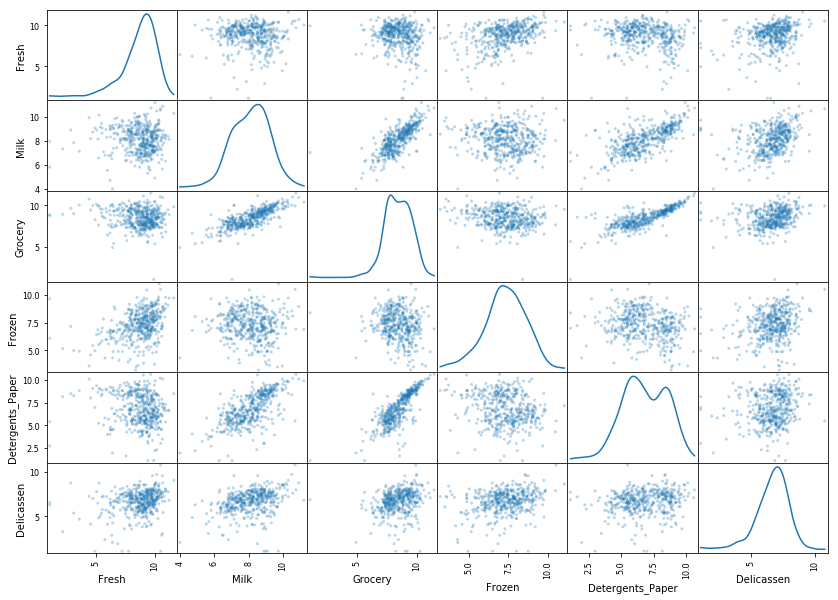

In [16]:
from pandas.plotting import scatter_matrix
scatter_matrix(log_data, alpha = 0.3, figsize = (14,10), diagonal = 'kde')

Before Log trasformation


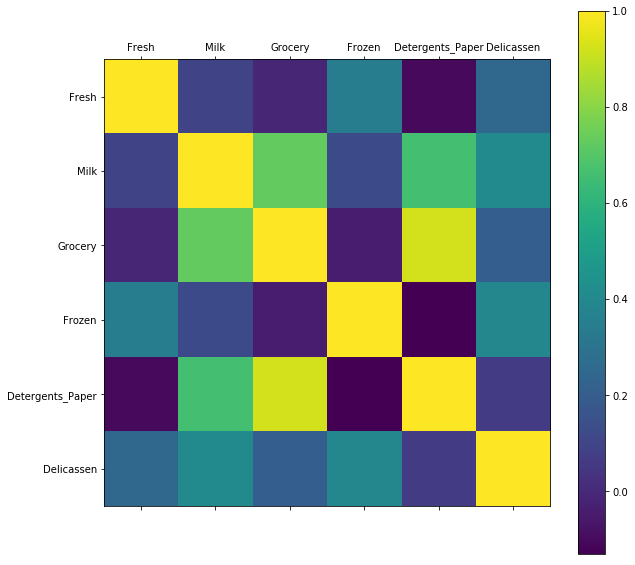

After Log trasformation


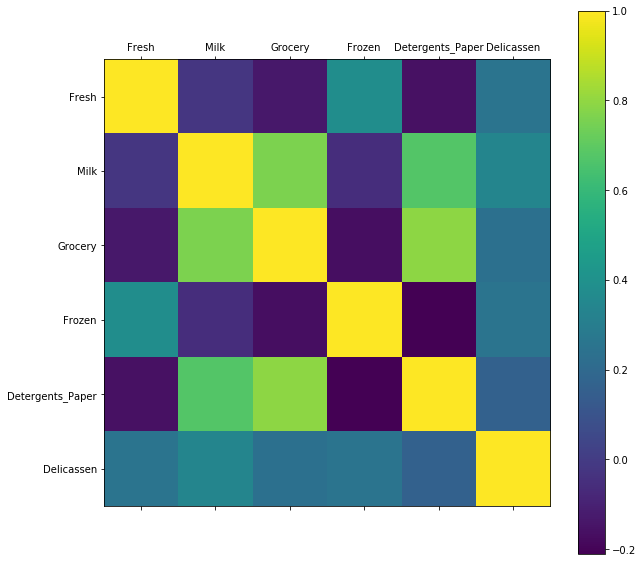

In [40]:
print("Before Log trasformation")
plot_corr(data)
print("After Log trasformation")
plot_corr(log_data)

**Changes in correlations:**
* Grocery and Detergents_Paper has a weaker correlation.
* Grocery and Milk has a slightly stronger correlation.
* Detergents_Paper and Milk has a slightly stronger correlation.

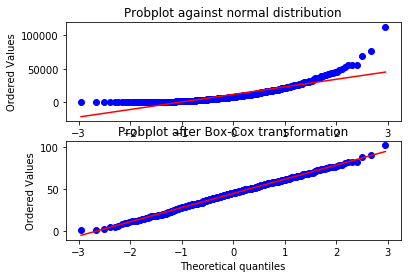

In [18]:
# Test Box-Cox power transformation on a feature of the dataset
from scipy import stats
fig = plt.figure()
ax1 = fig.add_subplot(211)
prob = stats.probplot(data['Fresh'], dist=stats.norm, plot=ax1)
ax1.set_xlabel('')
ax1.set_title('Probplot against normal distribution')

# We now use boxcox to transform the data so it’s closest to normal
ax2 = fig.add_subplot(212)
xt, lmbda = stats.boxcox(data['Fresh'])
prob = stats.probplot(xt, dist=stats.norm, plot=ax2)
ax2.set_title('Probplot after Box-Cox transformation')
plt.show()

# https://en.wikipedia.org/wiki/Normal_probability_plot
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.boxcox.html

#### Outlier Detection
We elimate outliers because they have important effect on clustering

In [19]:
outliers_lst = []
for feature in log_data.columns:
    Q1 = np.percentile(log_data[feature], 25)
    Q3 = np.percentile(log_data[feature], 75)
    step = 1.5*(Q3-Q1)
    outliers_rows = log_data[(log_data[feature] < Q1-step)|(log_data[feature] > Q3+step)]
    outliers_lst.append(list(outliers_rows.index))
    
import itertools
outliers = list(itertools.chain.from_iterable(outliers_lst))
uniq_outliers = list(set(outliers))
# find duplicated for more than one feature
dup_outliers = list(set([i for i in outliers if outliers.count(i)>1]))

print('Outliers list:\n', uniq_outliers)
print('Length of outliers list:\n', len(uniq_outliers))
print('Duplicate list:\n', dup_outliers)
print('Length of duplicates list:\n', len(dup_outliers))

# Remove duplicate outliers
good_data = log_data.drop(dup_outliers, axis=0).reset_index(drop = True)

print('Original shape of data:\n', data.shape)
print('New shape of data:\n', good_data.shape)

Outliers list:
 [128, 264, 137, 142, 145, 154, 412, 285, 161, 289, 420, 38, 171, 429, 175, 304, 305, 439, 183, 57, 184, 187, 65, 66, 193, 325, 75, 203, 81, 338, 86, 343, 218, 95, 96, 353, 98, 355, 356, 357, 233, 109]
Length of outliers list:
 42
Duplicate list:
 [128, 65, 66, 75, 154]
Length of duplicates list:
 5
Original shape of data:
 (440, 6)
New shape of data:
 (435, 6)


### Feature Transformation - PCA

In [20]:
from sklearn.decomposition import PCA

pca = PCA(n_components=6)
pca.fit(good_data)

PCA(copy=True, iterated_power='auto', n_components=6, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

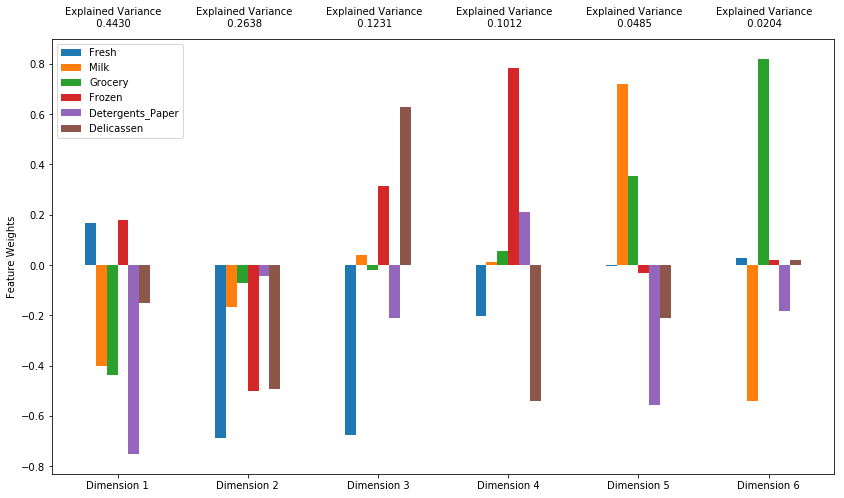

In [21]:
import renders as rs
pca_results = rs.pca_results(good_data, pca)

In [22]:
pca_results

,Explained Variance,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
Dimension 1,0.4430,0.1675,-0.4014,-0.4381,0.1782,-0.7514,-0.1499
Dimension 2,0.2638,-0.6859,-0.1672,-0.0707,-0.5005,-0.0424,-0.4941
Dimension 3,0.1231,-0.6774,0.0402,-0.0195,0.3150,-0.2117,0.6286
Dimension 4,0.1012,-0.2043,0.0128,0.0557,0.7854,0.2096,-0.5423
Dimension 5,0.0485,-0.0026,0.7192,0.3554,-0.0331,-0.5582,-0.2092
Dimension 6,0.0204,0.0292,-0.5402,0.8205,0.0205,-0.1824,0.0197


In [23]:
pca_results['Explained Variance'].cumsum()

Dimension 1    0.4430
Dimension 2    0.7068
Dimension 3    0.8299
Dimension 4    0.9311
Dimension 5    0.9796
Dimension 6    1.0000
Name: Explained Variance, dtype: float64

In [24]:
# Display sample log-data after having a PCA transformation applied
pca_samples = pca.transform(log_samples)
pd.DataFrame(np.round(pca_samples, 4), columns = pca_results.index.values)

,Dimension 1,Dimension 2,Dimension 3,Dimension 4,Dimension 5,Dimension 6
0,-3.1072,2.7017,-0.6386,1.8708,0.6452,0.1333
1,-2.2406,-1.2419,-1.0729,-1.9589,0.2160,-0.1782
2,3.0426,-2.5854,0.1965,-0.0757,-1.4213,0.0093


### Dimensionality Reduction

In [25]:
# We decide to retain only 2 components
pca = PCA(n_components=2)
pca.fit(good_data)
reduced_data = pca.transform(good_data)
pca_samples = pca.transform(log_samples)
# Create a DataFrame for the reduced data
reduced_data = pd.DataFrame(reduced_data, columns = ['Dimension 1', 'Dimension 2'])

In [26]:
# Display sample log-data after applying PCA transformation in two dimensions
pd.DataFrame(np.round(pca_samples, 4), columns = ['Dimension 1', 'Dimension 2'])

,Dimension 1,Dimension 2
0,-3.1072,2.7017
1,-2.2406,-1.2419
2,3.0426,-2.5854


The values for the first two dimensions remains unchanged when compared to a PCA transformation in six dimensions.

### Creating Clusters

In [27]:
from sklearn.mixture import GaussianMixture 
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [28]:
# Create range of clusters 
range_n_clusters = list(range(2,11))

**GMM Implementation**

In [29]:
for n_clusters in range_n_clusters:
    # Fit Gaussian Mixture Model
    clusterer = GaussianMixture(n_components=n_clusters).fit(reduced_data)
    preds = clusterer.predict(reduced_data)
    #centers = clusterer.means_
    score = silhouette_score(reduced_data, preds, metric='mahalanobis')
    print("For n_clusters = {}. The average silhouette_score is : {}".format(n_clusters, score))

For n_clusters = 2. The average silhouette_score is : 0.37598604546578696
For n_clusters = 3. The average silhouette_score is : 0.33424222312146806
For n_clusters = 4. The average silhouette_score is : 0.292820277773402
For n_clusters = 5. The average silhouette_score is : 0.18558229390989633
For n_clusters = 6. The average silhouette_score is : 0.31481379603387655
For n_clusters = 7. The average silhouette_score is : 0.32413288372063537
For n_clusters = 8. The average silhouette_score is : 0.3329506588276869
For n_clusters = 9. The average silhouette_score is : 0.2834306206276476
For n_clusters = 10. The average silhouette_score is : 0.2834416793491271


**KNN implementation**

In [30]:
for n_clusters in range_n_clusters:
    # Fit K-Means Model
    clusterer = KMeans(n_clusters=n_clusters).fit(reduced_data)
    preds = clusterer.predict(reduced_data)
    #centers = clusterer.means_    
    score = silhouette_score(reduced_data, preds, metric='euclidean')
    print("For n_clusters = {}. The average silhouette_score is : {}".format(n_clusters, score))

For n_clusters = 2. The average silhouette_score is : 0.42628101546910835
For n_clusters = 3. The average silhouette_score is : 0.39689092644980506
For n_clusters = 4. The average silhouette_score is : 0.33293041968141934
For n_clusters = 5. The average silhouette_score is : 0.3496074606159664
For n_clusters = 6. The average silhouette_score is : 0.3646577092055072
For n_clusters = 7. The average silhouette_score is : 0.3648753591099507
For n_clusters = 8. The average silhouette_score is : 0.3556302714545313
For n_clusters = 9. The average silhouette_score is : 0.35737574555961177
For n_clusters = 10. The average silhouette_score is : 0.34627444498391197


For both GMM and KNN the best score is obtained when the number of clusters is 2. 

**Cluster Visualization**

In [33]:
clusterer = GaussianMixture(n_components=2).fit(reduced_data)
preds = clusterer.predict(reduced_data)
centers = clusterer.means_
sample_preds = clusterer.predict(pca_samples)

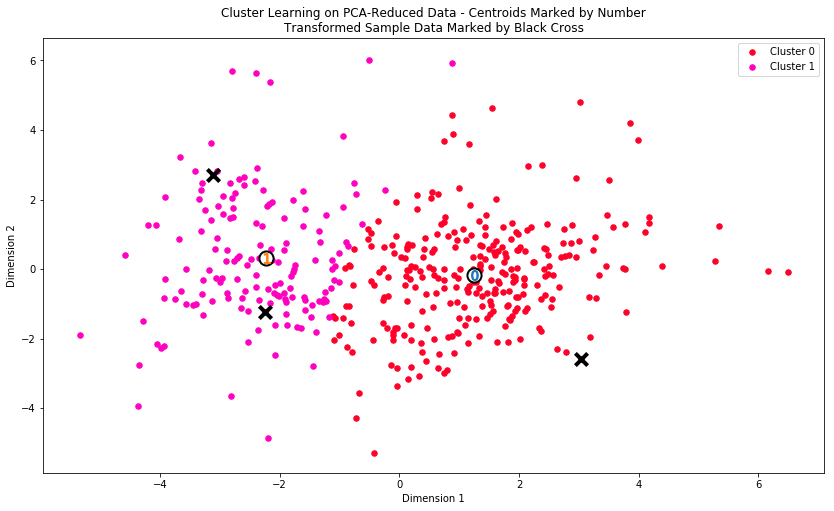

In [34]:
rs.cluster_results(reduced_data, preds, centers, pca_samples)

**Data Recovery**

In [35]:
log_centers = pca.inverse_transform(centers)
true_centers = np.exp(log_centers)

segments = ['Segment {}'.format(i) for i in range(0,len(centers))]
true_centers  = pd.DataFrame(np.round(true_centers), columns=data.columns)
true_centers.index = segments
true_centers 

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
Segment 0,8953.0,2114.0,2765.0,2075.0,353.0,732.0
Segment 1,3552.0,7837.0,12219.0,870.0,4696.0,962.0


What set of establishments could each of the customer segments represent?

In [36]:
true_centers - data.median()

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
Segment 0,449.0,-1513.0,-1990.5,549.0,-463.5,-233.5
Segment 1,-4952.0,4210.0,7463.5,-656.0,3879.5,-3.5


**Segment 0** has above median spending on "Milk", "Grocery" and "Detergents_Paper": This could represent *restaurants* and *cafes*.  
**Segment 1** has above median spending on "Fresh" and "Frozen". This could represent typical retailers such as markets specializing in fresh and frozen food. This is typical in *seafood* or *meat markets*.

In [37]:
# Display the predictions
for i, pred in enumerate(sample_preds):
    print("Sample point", i, "predicted to be in Cluster", pred)

Sample point 0 predicted to be in Cluster 1
Sample point 1 predicted to be in Cluster 1
Sample point 2 predicted to be in Cluster 0


In [38]:
samples

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
43,630,11095,23998,787,9529,72
12,31714,12319,11757,287,3881,2931
39,56159,555,902,10002,212,2916


**References:**  
https://www.ritchieng.com/machine-learning-project-customer-segments/  
https://dominicbreuker.com/customer_segments/  
https://github.com/ritchieng/machine-learning-nanodegree